#

# Introduction

This notebook uses the utils in this codebase to perform end-to-end machine learning on the [Criteo Display Ads Challenge Dataset](https://paperswithcode.com/dataset/criteo). 

The aim of this challenge is to predict click-through-rates (CTR) for ads, based on anonmysised Criteo logs data. Predicting CTR or other forms of engagements is also done in search ranking. We use pointwise ranking approaches in this notebook.

The main difference is that these ads do not belong to a specific user's query and corresponding impressions, so we cannot calculate ranking metrics. However, we can calculate pointwise metrics.

# Setup

In [93]:
import numpy as np
import pandas as pd
import logging

# Data is not committed in this repo
train = pd.read_csv("../data/criteo/train.csv")
test = pd.read_csv("../data/criteo/test.csv")

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
)

# EDA

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Label     20000 non-null  int64  
 1   I1        11035 non-null  float64
 2   I2        20000 non-null  int64  
 3   I3        16025 non-null  float64
 4   I4        16121 non-null  float64
 5   I5        19012 non-null  float64
 6   I6        14945 non-null  float64
 7   I7        18994 non-null  float64
 8   I8        19982 non-null  float64
 9   I9        18994 non-null  float64
 10  I10       11035 non-null  float64
 11  I11       18994 non-null  float64
 12  I12       4522 non-null   float64
 13  I13       16121 non-null  float64
 14  C1        20000 non-null  object 
 15  C2        20000 non-null  object 
 16  C3        19229 non-null  object 
 17  C4        19229 non-null  object 
 18  C5        20000 non-null  object 
 19  C6        17287 non-null  object 
 20  C7        20000 non-null  ob

In [63]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Label     20000 non-null  int64  
 1   I1        11106 non-null  float64
 2   I2        20000 non-null  int64  
 3   I3        16191 non-null  float64
 4   I4        16150 non-null  float64
 5   I5        18989 non-null  float64
 6   I6        14903 non-null  float64
 7   I7        19032 non-null  float64
 8   I8        19980 non-null  float64
 9   I9        19032 non-null  float64
 10  I10       11106 non-null  float64
 11  I11       19032 non-null  float64
 12  I12       4574 non-null   float64
 13  I13       16150 non-null  float64
 14  C1        20000 non-null  object 
 15  C2        20000 non-null  object 
 16  C3        19220 non-null  object 
 17  C4        19220 non-null  object 
 18  C5        20000 non-null  object 
 19  C6        17173 non-null  object 
 20  C7        20000 non-null  ob

In [64]:
# Check proportion of duplicate rows
(len(train) - len(train.drop_duplicates())) / len(train)
train = train.drop_duplicates()

In [65]:
# Check for constant features
unique_count = train.nunique()
unique_count[unique_count == 1]

query_id    1
dtype: int64

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = train.select_dtypes([np.float64, np.int64, np.int32]).drop("Label", axis=1).columns
categorical_features = train.select_dtypes([np.object_]).columns

<Axes: >

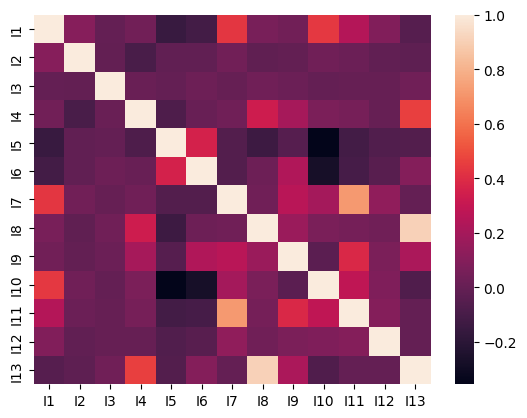

In [67]:
sns.heatmap(train[numerical_features].corr())

In [68]:
# Distributions of actual features
# We'll just look at a sample
QUANTILES = [0.001, 0.01, 0.25, 0.75, 0.99, 0.999]
for feature in numerical_features[:5]:
    quantiles = {
        quantile: train[feature].quantile(quantile)
        for quantile in QUANTILES
    }
    print(f"Feature {feature} quantiles: {quantiles}") 

Feature I1 quantiles: {0.001: 0.0, 0.01: 0.0, 0.25: 0.0, 0.75: 3.0, 0.99: 42.0, 0.999: 106.8640000000014}
Feature I2 quantiles: {0.001: -1.0, 0.01: -1.0, 0.25: 0.0, 0.75: 39.0, 0.99: 2326.0200000000004, 0.999: 3582.0280000000057}
Feature I3 quantiles: {0.001: 0.0, 0.01: 1.0, 0.25: 2.0, 0.75: 22.0, 0.99: 310.77000000000044, 0.999: 3432.085000001567}
Feature I4 quantiles: {0.001: 0.0, 0.01: 0.0, 0.25: 2.0, 0.75: 11.0, 0.99: 45.0, 0.999: 80.0}
Feature I5 quantiles: {0.001: 0.0, 0.01: 0.0, 0.25: 241.0, 0.75: 10397.5, 0.99: 333464.4000000003, 0.999: 782331.8400000109}


In [69]:
# Looks like its just the higher values that take on extreme values
# We'll round them down to the 99th percentile
for feature in numerical_features:
    percentile_99 = train[feature].quantile(0.99)
    train[feature] = train[feature].apply(lambda x: min(x, percentile_99))

QUANTILES = [0.001, 0.01, 0.25, 0.75, 0.99, 0.999]
for feature in numerical_features[:5]:
    quantiles = {
        quantile: train[feature].quantile(quantile)
        for quantile in QUANTILES
    }
    print(f"Feature {feature} quantiles: {quantiles}") 

Feature I1 quantiles: {0.001: 0.0, 0.01: 0.0, 0.25: 0.0, 0.75: 3.0, 0.99: 42.0, 0.999: 42.0}
Feature I2 quantiles: {0.001: -1.0, 0.01: -1.0, 0.25: 0.0, 0.75: 39.0, 0.99: 2326.0004, 0.999: 2326.0200000000004}
Feature I3 quantiles: {0.001: 0.0, 0.01: 1.0, 0.25: 2.0, 0.75: 22.0, 0.99: 310.59290000000067, 0.999: 310.77000000000044}
Feature I4 quantiles: {0.001: 0.0, 0.01: 0.0, 0.25: 2.0, 0.75: 11.0, 0.99: 45.0, 0.999: 45.0}
Feature I5 quantiles: {0.001: 0.0, 0.01: 0.0, 0.25: 241.0, 0.75: 10397.5, 0.99: 333444.96000000054, 0.999: 333464.4000000003}


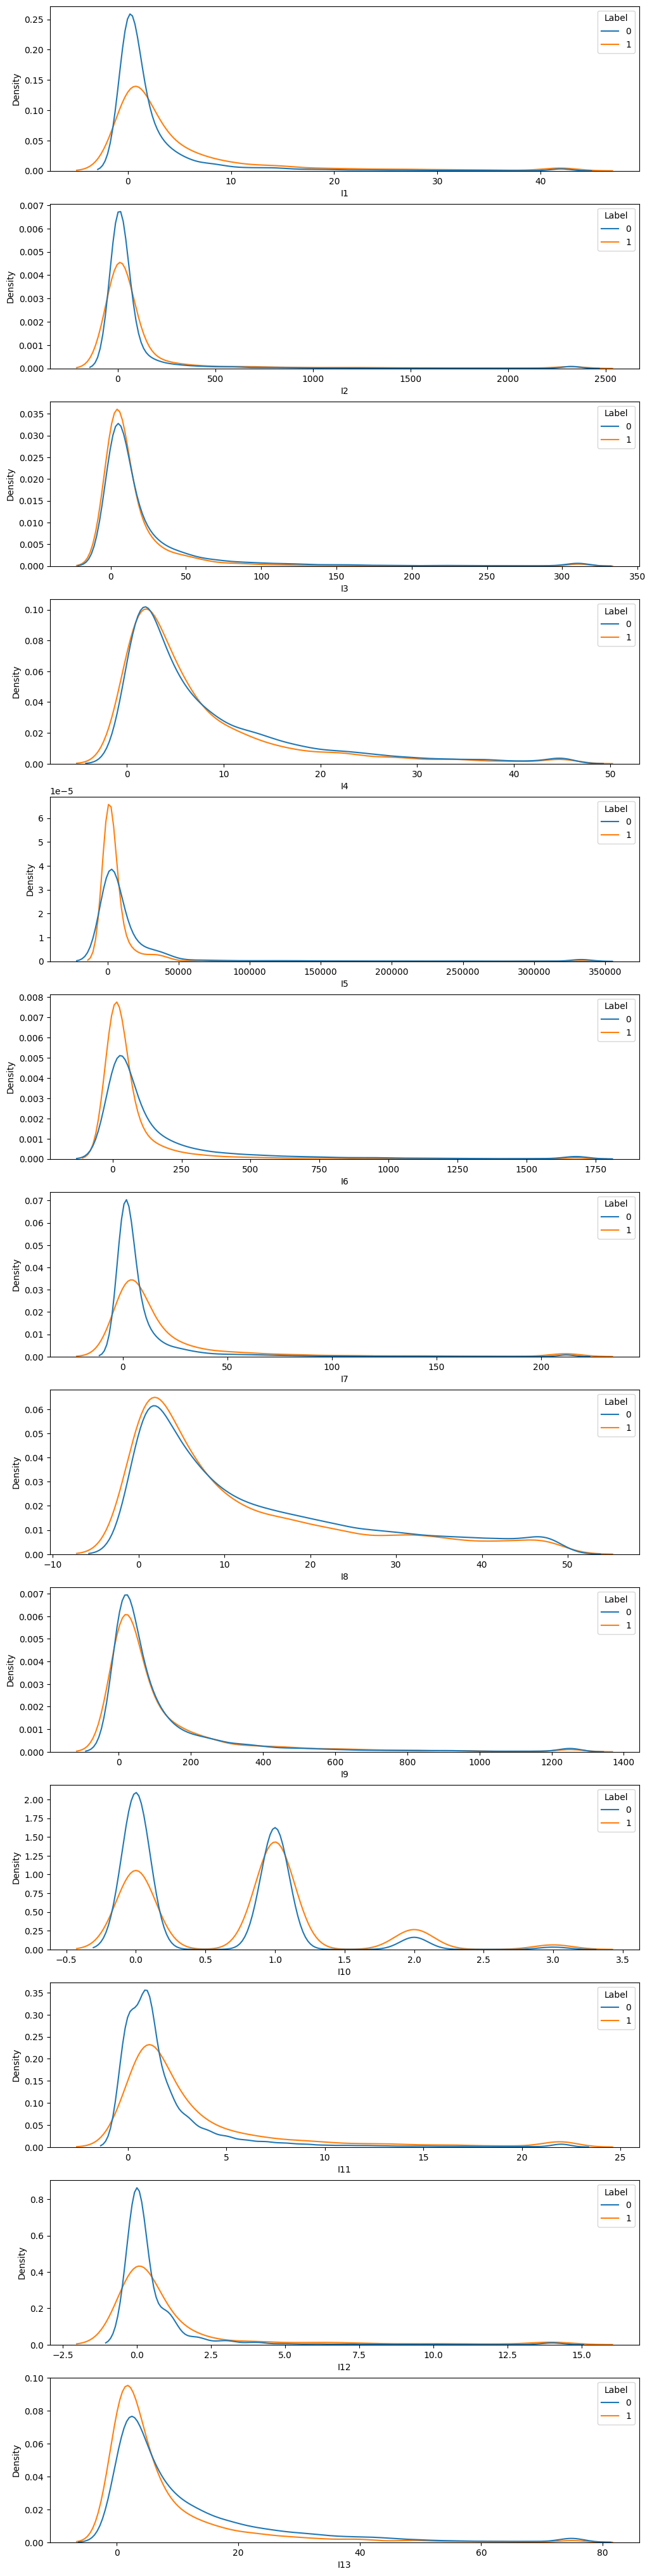

In [70]:
# Now we have handled outliers, try plotting 
fig,axes = plt.subplots(len(numerical_features), figsize=(12, len(numerical_features) * 4))
for i,feature in enumerate(numerical_features):
    sns.kdeplot(data=train, x=feature, common_norm=False, hue="Label", ax=axes[i])

Looks like I1, I5, I6 have particularly different distributions between label values. Since I5 and I6 are quite correlated, we choose I6 as it has a smoother distribution suggesting it is less noisy.

In [71]:
for feature in categorical_features:
    print(f"Feature {feature} unique values: {train[feature].nunique()}")

Feature C1 unique values: 236
Feature C2 unique values: 430
Feature C3 unique values: 10179
Feature C4 unique values: 6944
Feature C5 unique values: 72
Feature C6 unique values: 10
Feature C7 unique values: 4488
Feature C8 unique values: 128
Feature C9 unique values: 3
Feature C10 unique values: 4597
Feature C11 unique values: 2652
Feature C12 unique values: 9690
Feature C13 unique values: 2130
Feature C14 unique values: 25
Feature C15 unique values: 2786
Feature C16 unique values: 8437
Feature C17 unique values: 9
Feature C18 unique values: 1494
Feature C19 unique values: 735
Feature C20 unique values: 3
Feature C21 unique values: 9170
Feature C22 unique values: 10
Feature C23 unique values: 14
Feature C24 unique values: 4077
Feature C25 unique values: 41
Feature C26 unique values: 3151
Feature query_id unique values: 1


For categorical features, we will look at the highest 5 label probability = 1 and lowest 5 for each categorical feature

In [72]:
for feature in categorical_features:
    grouped = train.groupby(feature)["Label"].aggregate(["mean", "size"]).sort_values(by="mean", ascending=False)
    # Don't take those with absolute probs
    grouped = grouped[(grouped["mean"] > 0.0) & (grouped["mean"] < 1.0)]
    print(f"Feature {feature} Top 5: {grouped.head(5)}, Bottom 5: {grouped.tail(5)}")

Feature C1 Top 5:               mean  size
C1                      
0a16e1d4  0.666667     3
3560b08b  0.500000     6
c512b859  0.500000     2
6bcf7a5b  0.500000     2
9e9d28f5  0.500000     2, Bottom 5:               mean  size
C1                      
dac91c28  0.111111     9
ff004ae3  0.111111     9
87773c45  0.100000    10
9684fd4d  0.090909    11
64e77ae7  0.076923    13
Feature C2 Top 5:               mean  size
C2                      
d9060812  0.700000    10
c1c79489  0.666667     3
482fe41f  0.666667     3
5a88f1d5  0.666667     3
2a8248f5  0.666667     3, Bottom 5:               mean  size
C2                      
8ab240be  0.053333    75
d57c0709  0.047619    21
097e9399  0.043478    46
bc84a2bc  0.043478    23
8084ee93  0.036101   277
Feature C3 Top 5:               mean  size
C3                      
bce3f26f  0.857143     7
95c48c52  0.800000     5
c2b2b3f5  0.800000    10
6406abee  0.800000     5
d0c01507  0.800000     5, Bottom 5:               mean  size
C3           

There are lots of features, but let's use C4, C5 and C7 because they have quite a few categories with high label probs and low label probs.

This brings our feature set to:
- Numerical: I1, I5, I6
- Categorical: C4, C5, C7

# Data Preprocessing

In [73]:
# Everything is driven by the schema
schema_dict = {
    "features": {
        # "categorical": {
        #     "C4": {
        #         "impute": {
        #             "impute_type": "mode"
        #         }
        #     },
        #     "C5": {
        #         "impute": {
        #             "impute_type": "mode"
        #         }
        #     },
        #     "C7": {
        #         "impute": {
        #             "impute_type": "mode"
        #         }
        #     }
        # },
        "numerical": {
            "I1": {
                "impute": {
                    "impute_type": "mean"
                }
            },
            "I6": {
                "impute": {
                    "impute_type": "median"
                }
            }
        }
    },
    "target": "Label",
    "query_col": "query_id"
}

In [74]:
from typing import List, Optional, Any
from dataclasses import dataclass
import logging
import pandas as pd

logger = logging.getLogger(__name__)


class ImputeStrategy:
    VALID_TYPES = ["mean", "median", "mode", "min", "max", "val"]

    def __init__(self, impute_type: str, val: Optional[Any] = None):
        self.impute_type = impute_type
        self.val = val

    def _check_type_valid(self, impute_type: str):
        if impute_type not in self.VALID_TYPES:
            raise ValueError(
                f"impute_type must be in {self.VALID_TYPES}, got {impute_type}"
            )


@dataclass
class Feature:
    """
    Store information on features
    """

    name: str
    impute_strategy: ImputeStrategy

    @classmethod
    def get_instance_from_config(cls, f_name, f_config: dict):
        return cls(
            name=f_name, impute_strategy=ImputeStrategy(**f_config["impute"])
        )


class CategoricalFeature(Feature):
    VALID_IMPUTE_TYPES = ["mode", "val"]

    def __init__(self, name: str, impute_strategy: ImputeStrategy):
        super().__init__(name, impute_strategy)
        if self.impute_strategy.impute_type not in self.VALID_IMPUTE_TYPES:
            raise ValueError(
                f"Categorical feature must have impute type "
                f"in {self.VALID_IMPUTE_TYPES}, "
                f"got {self.impute_strategy.impute_type}"
            )


class Schema:
    def __init__(
        self,
        target: str,
        query_col: str,
        categorical_features: List[Optional[CategoricalFeature]] = [],
        numerical_features: List[Optional[Feature]] = [],
    ):
        self.target = target
        self.query_col = query_col
        self.categorical_features = categorical_features
        self.numerical_features = numerical_features
        self.all_features = categorical_features + numerical_features
        self.imputations = None
        self.normalisation_stats = None

    def set_imputations(self, df: pd.DataFrame) -> None:
        """
        Create a dictionary of feature to imputation value
        """
        imputations = {}
        for f in self.all_features:
            if f.impute_strategy.val:
                imputations[f.name] = f.impute_strategy.val
            else:
                impute_val = df[f.name].aggregate(
                    f.impute_strategy.impute_type
                )
                # Mode can be more than one value
                if f.impute_strategy.impute_type == "mode":
                    impute_val = impute_val[0]
                imputations[f.name] = impute_val
        self.imputations = imputations

    def set_norm_stats(self, df: pd.DataFrame) -> None:
        """
        Creates a dictionary for normalising features
        """
        norm_stats = {}
        for f in self.numerical_features:
            norm_stats[f.name] = {
                "mean": df[f.name].mean(),
                "std": df[f.name].std(),
            }
        self.norm_stats = norm_stats

    def set_vocabs(self, df: pd.DataFrame) -> None:
        """
        Creates a dictionary of categorical vocabs
        """
        vocabs = {}
        for f in self.categorical_features:
            # Don't want to include nan as a category
            vocabs[f.name] = list(
                df.sort_values(by=f.name)[f.name].dropna().unique()
            )
        self.vocabs = vocabs

    def set_stats(self, df: pd.DataFrame) -> None:
        self.set_imputations(df)
        self.set_norm_stats(df)
        self.set_vocabs(df)

    def get_model_features(self) -> List[str]:
        """
        In modelling, categorical cols get dropped
        Each categorical col is <col_name>_<cat_name>
        Requires vocab already set
        """
        if not hasattr(self, "vocabs"):
            raise NotImplementedError("Must set vocabs first")
        features = [f.name for f in self.numerical_features]
        for f in self.categorical_features:
            for category in self.vocabs[f.name]:
                features.append(f"{f.name}_{category}")
        return features

    @classmethod
    def create_instance_from_dict(cls, schema_dict: dict):
        logger.info(f"Creating schema using: {schema_dict}")
        categorical_features = []
        for f_name, f_config in (
            schema_dict["features"].get("categorical", {}).items()
        ):
            categorical_features.append(
                CategoricalFeature.get_instance_from_config(
                    f_name=f_name, f_config=f_config
                )
            )
        numerical_features = []
        for f_name, f_config in (
            schema_dict["features"].get("numerical", {}).items()
        ):
            numerical_features.append(
                Feature.get_instance_from_config(
                    f_name=f_name, f_config=f_config
                )
            )
        return cls(
            target=schema_dict["target"],
            query_col=schema_dict["query_col"],
            categorical_features=categorical_features,
            numerical_features=numerical_features,
        )

schema = Schema.create_instance_from_dict(schema_dict)

2024-07-27 22:33:25,289 | INFO | __main__ | Creating schema using: {'features': {'numerical': {'I1': {'impute': {'impute_type': 'mean'}}, 'I6': {'impute': {'impute_type': 'median'}}}}, 'target': 'Label', 'query_col': 'query_id'}


In [75]:
import logging
from typing import Tuple
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

logger = logging.getLogger(__name__)


def impute_df(df: pd.DataFrame, imputations: dict) -> pd.DataFrame:
    logger.info(f"Imputations: {imputations}")
    return df.fillna(imputations)


def normalise_numerical_features(
    df: pd.DataFrame, norm_stats: dict, epsilon: float = 1e-8
) -> pd.DataFrame:
    """
    Normalise features using pre-computed stats
    The `epsilon` param is to prevent zero division
    """
    df = df.copy()
    logger.info(f"Norm stats: {norm_stats}")
    for f, f_stats in norm_stats.items():
        f_mean = f_stats["mean"]
        f_std = epsilon if f_stats["std"] == 0 else f_stats["std"]
        df[f] = (df[f] - f_mean) / (f_std)
    return df


def create_one_hot_encoder(
    df: pd.DataFrame, schema: Schema
) -> "OneHotEncoder":
    """
    Create a one hot encoder object to encode categorical features
    Needs to be used for preprocessing validation data as well
    """
    categorical_feature_names = [f.name for f in schema.categorical_features]
    # Don't want it to error on validation data with unknown category
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    encoder.fit(df[categorical_feature_names])
    return encoder


def one_hot_encode_categorical_features(
    df: pd.DataFrame, one_hot_encoder: OneHotEncoder
) -> pd.DataFrame:
    """
    Append one hot encoded features to the data
    Also drop original categorical feature
    """
    categorical_features = one_hot_encoder.feature_names_in_
    categorical_data = df[categorical_features]
    # Create the OHE columns
    columns = []
    for i in range(len(categorical_features)):
        f = categorical_features[i]
        for category in one_hot_encoder.categories_[i]:
            columns.append(f"{f}_{category}")
    encoded = pd.DataFrame(
        one_hot_encoder.transform(categorical_data),
        columns=columns,
        index=df.index,
    )
    # Drop original categorical features and concat on
    df = df.drop(categorical_features, axis=1)
    return pd.concat([df, encoded], axis=1)


def drop_cols(df: pd.DataFrame, schema: Schema) -> pd.DataFrame:
    """
    Drop columns not specified in the schema
    """
    features = [f.name for f in schema.all_features]
    features.append(schema.target)
    features.append(schema.query_col)
    return df[features]


def split_dataset(
    df: pd.DataFrame, schema: Schema
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Return the original df, X and y
    Assumes data already preprocessed
    """
    X = df[schema.get_model_features()]
    y = df[schema.target]
    return df, X, y


In [76]:
import pandas as pd
class Preprocessor:
    """
    Combine all preprocessing steps that are relevant to the schema
    A dataframe is also needed to learn the preprocessing values
    """

    def __init__(self, base_df: pd.DataFrame, schema: Schema):
        self.base_df = base_df
        self.schema = schema

        # Optional Preprocessing objs
        if len(self.schema.categorical_features) > 0:
            self.one_hot_encoder = create_one_hot_encoder(
                self.base_df, self.schema
            )
        else:
            self.one_hot_encoder = None

    def __call__(
        self, df: pd.DataFrame, drop_redundant: bool = True
    ) -> pd.DataFrame:
        if drop_redundant:
            df = drop_cols(df, self.schema)
        df = impute_df(df, self.schema.imputations)
        if len(self.schema.numerical_features) > 0:
            df = normalise_numerical_features(df, self.schema.norm_stats)
        if self.one_hot_encoder:
            df = one_hot_encode_categorical_features(df, self.one_hot_encoder)
        return df


In [77]:
# Create preprocessor from training
schema.set_stats(train)
preprocessor = Preprocessor(
    train,
    schema
)

In [78]:
# We want to do the following
# Drop all un-used features
# Impute any missing values
# Normalise numerical data
# One hot encode categorical features
preprocessed_train = preprocessor(train)

2024-07-27 22:33:25,322 | INFO | __main__ | Imputations: {'I1': 3.167467149977345, 'I6': 40.0}
2024-07-27 22:33:25,324 | INFO | __main__ | Norm stats: {'I1': {'mean': 3.167467149977345, 'std': 6.6902148055332535}, 'I6': {'mean': 135.07674807627967, 'std': 261.20913555102317}}


# Model Training

In [79]:
# Code for getting any of the supported models using the name and config
from importlib import import_module
import logging

logger = logging.getLogger(__name__)


class ModelFactory:
    """
    Given a package module for a model cls and configreturn a model instance
    """

    def __init__(self):
        pass

    @classmethod
    def get_instance_from_config(
        cls, package_module_cls: str, config: dict = {}
    ):
        """
        Get the model's package module cls
        Create an instance using the config
        """
        model_cls_module, model_cls = package_module_cls.split(":")
        logger.info(f"Creating model: {model_cls_module} - {model_cls}")

        model_cls_obj = getattr(import_module(model_cls_module), model_cls)
        logger.info(f"Creating {model_cls} using {config}")
        return model_cls_obj(**config)


In [80]:
lr = ModelFactory.get_instance_from_config(
    "sklearn.linear_model:LogisticRegression",
    {
        "C": 0.01
    }
)
preprocessed_train, X, y = split_dataset(preprocessed_train, schema)

lr.fit(X, y)

2024-07-27 22:33:25,411 | INFO | __main__ | Creating model: sklearn.linear_model - LogisticRegression
2024-07-27 22:33:25,427 | INFO | __main__ | Creating LogisticRegression using {'C': 0.01}


LogisticRegression(C=0.01)

# Evaluation

In [81]:
preprocessed_train["lr_prediction"] = lr.predict_proba(X)[:, 1]

In [82]:
preprocessed_test = preprocessor(test)
preprocessed_test, test_X, test_y = split_dataset(preprocessed_test, schema)
preprocessed_test["lr_prediction"] = lr.predict_proba(test_X)[:, 1]

2024-07-27 22:33:25,559 | INFO | __main__ | Imputations: {'I1': 3.167467149977345, 'I6': 40.0}
2024-07-27 22:33:25,561 | INFO | __main__ | Norm stats: {'I1': {'mean': 3.167467149977345, 'std': 6.6902148055332535}, 'I6': {'mean': 135.07674807627967, 'std': 261.20913555102317}}


In [83]:
from typing import List, Dict
import numpy as np
import pandas as pd
from importlib import import_module

SKLEARN_METRICS_MODULE = import_module("sklearn.metrics")


def get_pointwise_metrics(
    df: pd.DataFrame,
    schema: Schema,
    y_pred_col: str,
    pointwise_metrics: List[str],
) -> Dict[str, float]:
    """
    Calculate all of the desired pointwise metrics on y_true and y_pred
    """
    metrics = {}
    for metric in pointwise_metrics:
        metric_func = getattr(SKLEARN_METRICS_MODULE, metric)
        metrics[metric] = metric_func(df[schema.target], df[y_pred_col])
    return metrics


def calculate_query_ranking_metric(
    y_true: pd.Series, y_pred: pd.Series, ranking_metric_name: str
) -> float:
    """
    For a single query, calculate a ranking metric
    Needs to be done query by query as variable length queries
    Each pd.Series contains an array of actual/predicted scores
    Then average the query scores at the end
    """
    metric_func = getattr(SKLEARN_METRICS_MODULE, ranking_metric_name)
    query_metrics = np.array([])
    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must be the same length")
    for i in range(len(y_true)):
        # Needs to be 2-D for ranking metric calculation
        y_true_arr = np.array(y_true[i]).reshape(1, -1)
        y_pred_arr = np.array(y_pred[i]).reshape(1, -1)
        query_metrics = np.append(
            query_metrics, metric_func(y_true_arr, y_pred_arr)
        )
    return query_metrics.mean()


def get_ranking_metrics(
    df: pd.DataFrame,
    schema: Schema,
    y_pred_col: str,
    ranking_metrics: List[str],
) -> Dict[str, float]:
    metrics = {}
    y_true_queries = df.groupby(schema.query_col)[schema.target].agg(list)
    # Remove all queries of size 1 as can't rank
    # Also remove any queries which had no relevant items
    drop_indices = (y_true_queries.apply(lambda x: len(x) > 1)) & (
        y_true_queries.apply(lambda x: sum(x) > 0)
    )
    y_true_queries = y_true_queries[drop_indices]
    y_pred_queries = df.groupby(schema.query_col)[y_pred_col].agg(list)[
        drop_indices
    ]
    for metric in ranking_metrics:
        metrics[metric] = calculate_query_ranking_metric(
            y_true_queries, y_pred_queries, metric
        )
    return metrics


In [84]:
lr_train_metrics = get_pointwise_metrics(
    preprocessed_train,
    schema,
    "lr_prediction",
    ["roc_auc_score", "log_loss", "brier_score_loss"]
)

lr_test_metrics = get_pointwise_metrics(
    preprocessed_test,
    schema,
    "lr_prediction",
    ["roc_auc_score", "log_loss", "brier_score_loss"]
)

print(f"LR Train: {lr_train_metrics}")
print(f"LR Test: {lr_test_metrics}")

LR Train: {'roc_auc_score': 0.6012388211989317, 'log_loss': 0.5221563788010333, 'brier_score_loss': 0.17006987325721118}
LR Test: {'roc_auc_score': 0.6096525955210053, 'log_loss': 0.5238527426856897, 'brier_score_loss': 0.16975908475931753}


In [85]:
# Try a more sophisticated model
random_forest = ModelFactory.get_instance_from_config(
    "sklearn.ensemble:RandomForestClassifier",
    {
        "n_estimators": 50,
        "max_depth": 50
    }
)

random_forest.fit(X, y)
preprocessed_train["rf_prediction"] = random_forest.predict_proba(X)[:, 1]
preprocessed_test["rf_prediction"] = random_forest.predict_proba(test_X)[:, 1]

rf_train_metrics = get_pointwise_metrics(
    preprocessed_train,
    schema,
    "rf_prediction",
    ["roc_auc_score", "log_loss", "brier_score_loss"]
)
rf_test_metrics = get_pointwise_metrics(
    preprocessed_test,
    schema,
    "rf_prediction",
    ["roc_auc_score", "log_loss", "brier_score_loss"]
)

print(f"RF Train: {rf_train_metrics}")
print(f"RF Test: {rf_test_metrics}")

2024-07-27 22:33:25,654 | INFO | __main__ | Creating model: sklearn.ensemble - RandomForestClassifier
2024-07-27 22:33:25,656 | INFO | __main__ | Creating RandomForestClassifier using {'n_estimators': 50, 'max_depth': 50}


RF Train: {'roc_auc_score': 0.784619598668903, 'log_loss': 0.42798394183433675, 'brier_score_loss': 0.1386760852758602}
RF Test: {'roc_auc_score': 0.6417656404572201, 'log_loss': 1.00081994229673, 'brier_score_loss': 0.1737974973378611}


In [86]:
# Try a more sophisticated model again
xgb = ModelFactory.get_instance_from_config(
    "xgboost:XGBClassifier",
    {
        "n_estimators": 50,
        "max_depth": 6
    }
)

xgb.fit(X, y)
preprocessed_train["xgb_prediction"] = xgb.predict_proba(X)[:, 1]
preprocessed_test["xgb_prediction"] = xgb.predict_proba(test_X)[:, 1]

xgb_train_metrics = get_pointwise_metrics(
    preprocessed_train,
    schema,
    "xgb_prediction",
    ["roc_auc_score", "log_loss", "brier_score_loss"]
)
xgb_test_metrics = get_pointwise_metrics(
    preprocessed_test,
    schema,
    "xgb_prediction",
    ["roc_auc_score", "log_loss", "brier_score_loss"]
)

print(f"XGB Train: {xgb_train_metrics}")
print(f"XGB Test: {xgb_test_metrics}")

2024-07-27 22:33:26,294 | INFO | __main__ | Creating model: xgboost - XGBClassifier
2024-07-27 22:33:26,295 | INFO | __main__ | Creating XGBClassifier using {'n_estimators': 50, 'max_depth': 6}


XGB Train: {'roc_auc_score': 0.7206886137721951, 'log_loss': 0.4728467559170111, 'brier_score_loss': 0.15166344317034508}
XGB Test: {'roc_auc_score': 0.6821829254126847, 'log_loss': 0.4944155000004293, 'brier_score_loss': 0.15967056204669888}


In [87]:
# Try a more sophisticated model again
deep_feature_names = [f.name for f in schema.numerical_features]
wide_feature_names = [f for f in schema.get_model_features() if f not in deep_feature_names]
wide_deep = ModelFactory.get_instance_from_config(
    "search_ranking_utils.modelling.models.wide_deep_model:WideDeepModel",
    {
        "hidden_units": [64, 32, 8],
        "deep_feature_names": deep_feature_names,
        "wide_feature_names": wide_feature_names
    }
)

wide_deep.fit(X, y, 1024, epochs=5)
preprocessed_train["wide_deep_prediction"] = wide_deep.predict_proba(X)[:, 1]
preprocessed_test["wide_deep_prediction"] = wide_deep.predict_proba(test_X)[:, 1]

wide_deep_train_metrics = get_pointwise_metrics(
    preprocessed_train,
    schema,
    "wide_deep_prediction",
    ["roc_auc_score", "log_loss", "brier_score_loss"]
)
wide_deep_test_metrics = get_pointwise_metrics(
    preprocessed_test,
    schema,
    "wide_deep_prediction",
    ["roc_auc_score", "log_loss", "brier_score_loss"]
)

print(f"Wide Deep Train: {wide_deep_train_metrics}")
print(f"Wide Deep Test: {wide_deep_test_metrics}")

2024-07-27 22:33:26,408 | INFO | __main__ | Creating model: search_ranking_utils.modelling.models.wide_deep_model - WideDeepModel
2024-07-27 22:33:26,409 | INFO | __main__ | Creating WideDeepModel using {'hidden_units': [64, 32, 8], 'deep_feature_names': ['I1', 'I6'], 'wide_feature_names': []}


Epoch 1/5
20/20 [==============================] - 0s 1ms/step - loss: 0.6322 - auc: 0.5377
Epoch 2/5
20/20 [==============================] - 0s 1ms/step - loss: 0.5443 - auc: 0.4903
Epoch 3/5
20/20 [==============================] - 0s 1ms/step - loss: 0.5287 - auc: 0.5783
Epoch 4/5
20/20 [==============================] - 0s 1ms/step - loss: 0.5175 - auc: 0.6230
Epoch 5/5
20/20 [==============================] - 0s 1ms/step - loss: 0.5122 - auc: 0.6365
Wide Deep Train: {'roc_auc_score': 0.6412257776178344, 'log_loss': 0.5095695601724761, 'brier_score_loss': 0.16543882125735504}
Wide Deep Test: {'roc_auc_score': 0.6557845603251461, 'log_loss': 0.5058214530226188, 'brier_score_loss': 0.16391308593615753}


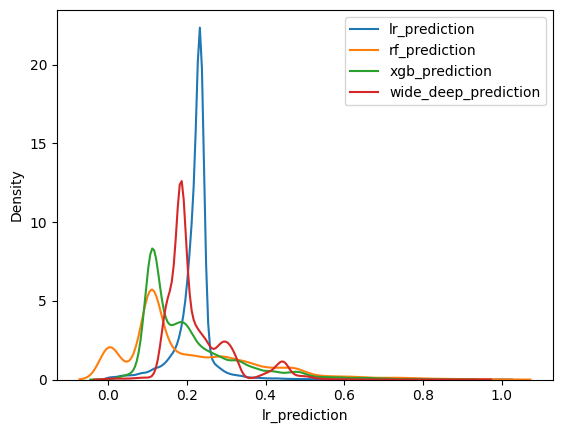

In [88]:
# Look at the distribution of true negatives
axes = plt.subplot()
score_cols = ["lr_prediction", "rf_prediction", "xgb_prediction", "wide_deep_prediction"]
for col in score_cols:
    sns.kdeplot(data=preprocessed_test[preprocessed_test["Label"] == 0], x=col, common_norm=False, ax=axes, label=col,)
plt.legend()

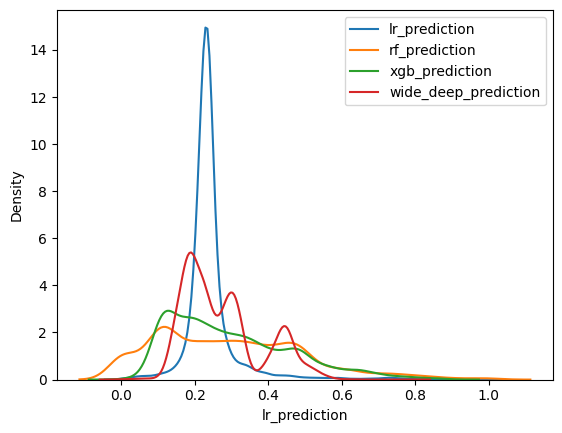

In [89]:
# Look at the distribution of true positives
axes = plt.subplot()
score_cols = ["lr_prediction", "rf_prediction", "xgb_prediction", "wide_deep_prediction"]
for col in score_cols:
    sns.kdeplot(data=preprocessed_test[preprocessed_test["Label"] == 1], x=col, common_norm=False, ax=axes, label=col,)
plt.legend()

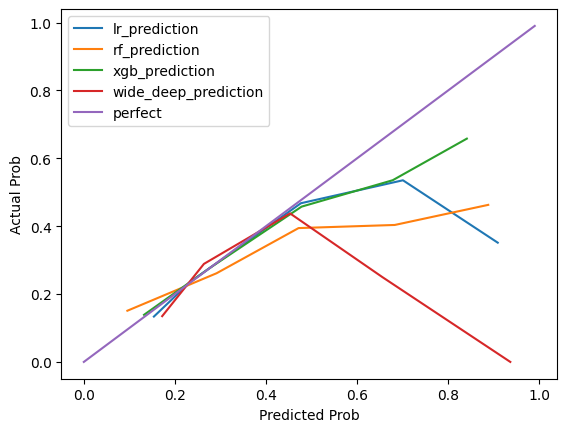

In [90]:
# Look at Calibration curves
from sklearn.calibration import calibration_curve
axes = plt.subplot()
score_cols = ["lr_prediction", "rf_prediction", "xgb_prediction", "wide_deep_prediction"]
for col in score_cols:
    prob_true, prob_pred = calibration_curve(preprocessed_test["Label"], preprocessed_test[col])
    plt.plot(prob_pred, prob_true, label=col)
plt.plot(np.arange(0, 1.0, 0.01), np.arange(0, 1.0, 0.01), label="perfect")
plt.xlabel("Predicted Prob")
plt.ylabel("Actual Prob")
plt.legend()

In [91]:
# For calculating feature importance

from typing import Tuple
import numpy as np
import pandas as pd
import shap


def calculate_feature_importance(
    df: pd.DataFrame, schema: dict, model, sample_size=None
) -> Tuple[np.ndarray, pd.DataFrame]:
    """
    Given a preprocessed dataset, calcualte feature importance
    """
    df, X, y = split_dataset(df, schema)
    if sample_size:
        X = X.sample(n=sample_size)

    # Use Shap kernel predict by defining inner function
    def f(X):
        return model.predict_proba(X)[:, 1]

    # Used as the background values to sample from
    background = _generate_background(X)

    explainer = shap.Explainer(f, background)
    shap_values = explainer(X).values
    shap_df = pd.DataFrame(shap_values, columns=X.columns).mean()
    return shap_values, shap_df


def _generate_background(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate background samples using medians
    Assumes df is preprocessed, no categorical features
    """
    background = df.head(1)
    background[df.columns] = df.median()
    return background


In [92]:
f_importance = preprocessed_test.drop(score_cols, axis=1)
shap_values, shap_df = calculate_feature_importance(f_importance, schema, lr, sample_size=5)

/var/folders/9f/r9py2tr53lg_d12zfq21zb5r0000gn/T/ipykernel_47456/499268806.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  background[df.columns] = df.median()
/var/folders/9f/r9py2tr53lg_d12zfq21zb5r0000gn/T/ipykernel_47456/499268806.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  background[df.columns] = df.median()


IndexError: index 0 is out of bounds for axis 0 with size 0

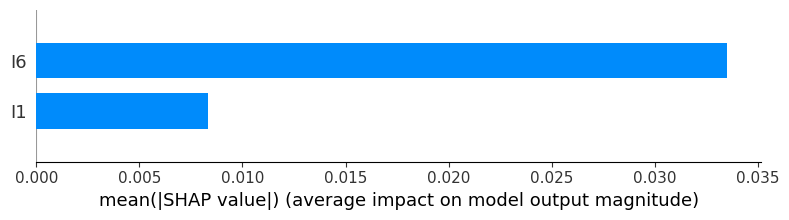

In [ ]:
shap.summary_plot(
    shap_values,
    plot_type="bar",
    feature_names=shap_df.index
)